In [7]:
from fastai.text import *
import pandas as pd
from sklearn.utils import shuffle

In [16]:
labeled = pd.read_csv("labeled_data.csv")
unlabel = pd.read_csv("unlabeled_data.csv")
test = pd.read_csv('test_data.csv')

In [19]:
# Drop duplicates of labeled data
# for data have same text and different labels we delete both 
# for data have same text and same labels, we keep first
labeled.drop_duplicates(subset=['text','label'], keep='first', inplace=True)
labeled.drop_duplicates(subset=['text'], keep=False, inplace=True)
labeled.shape

(49994, 2)

In [11]:
def convert(num):
    return str(num)
train.label = train.label.apply(convert)
train.head()

,text,label
0,The new rule is - \r\nif you are waiting for a...,4
1,"Flirted with giving this two stars, but that's...",3
2,I was staying at planet Hollywood across the s...,5
3,Food is good but prices are super expensive. ...,2
4,Worse company to deal with they do horrible wo...,1


In [20]:
all_data = pd.concat([labeled,unlabel],axis=0,sort=False)
all_data.shape

(649994, 2)

In [21]:
#drop duplicate text in ulanbeled data
all_data.drop_duplicates(subset=['text'], keep='first', inplace=True)
all_data.shape

(604263, 2)

In [29]:
#Slice non-duplicated unlabeled data
unlabel = all_data.iloc[49994:,:]

In [23]:
#File path
path = Path('./')

In [29]:
# Fine tune the generative language model
data_lm = TextLMDataBunch.from_df(path, train_df=all_data.iloc[:500000,:], valid_df=data.iloc[500000:,:], text_cols=0, bs=32)
learn = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


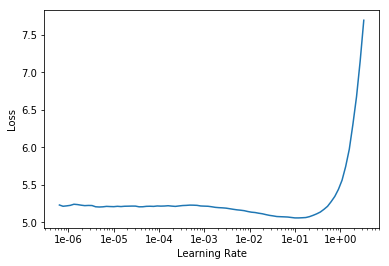

In [31]:
#Find the best learning rate
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [89]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.446659,6.019159,0.000823,5:48:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


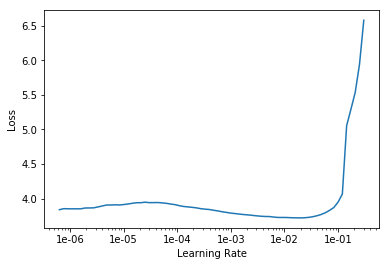

In [171]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [174]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.411457,6.270732,0.000813,5:47:39


In [206]:
#test the fine tuned generative language model
TEXT = "The delicious food "
N_WORDS = 20
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

# save encoder
learn.save_encoder('1')

In [264]:
#Sclice the training and validation set
train = shuffle(train)
val = train.iloc[45000:,:]
tr = train.iloc[:45000,:]

In [265]:
#Add weight to class 2,3,4
tr2 = shuffle(tr[tr.label=='2']).iloc[:1000,:]
tr3 = shuffle(tr[tr.label=='3']).iloc[:1500,:]
tr4 = shuffle(tr[tr.label=='4']).iloc[:1000,:]

In [266]:
tr = shuffle(pd.concat([tr,tr2,tr3,tr4]))

In [268]:
tr.shape

(48500, 2)

In [269]:
test['label'] = '-1'
# test = test.iloc[:,1:]
test.head()

,text,label
0,trying to have a nice quiet dinner. the annou...,-1
1,Been getting food to go from here for over 3yr...,-1
2,Ugh. I've had to eat here a couple of times be...,-1
3,The people here are so nice! I ordered on eat ...,-1
4,Heard alot of good things about this place and...,-1


In [270]:
# create test classes
data_clas = TextClasDataBunch.from_df(path =path, train_df=tr, valid_df =val,  test_df=test, vocab=data_lm.train_ds.vocab, text_cols=0, label_cols=1, bs=32)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


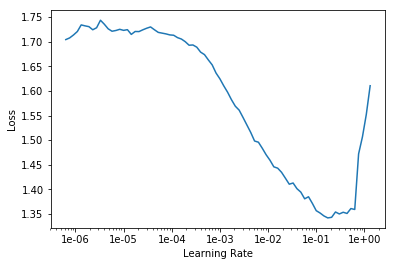

In [271]:
# train the classifier model
learn = text_classifier_learner(data_clas, arch = AWD_LSTM, pretrained = True, drop_mult=0.3)
learn.load_encoder('1')

# find and plot learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-3)

# unfreeze one layer group and train another epoch
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-4/2., 5e-4))

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/2., 5e-4))

learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-4/100, 2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.893076,0.818984,0.635963,07:45


epoch,train_loss,valid_loss,accuracy,time
0,0.866895,0.805274,0.644774,11:10


epoch,train_loss,valid_loss,accuracy,time
0,0.822676,0.771643,0.665799,14:37


epoch,train_loss,valid_loss,accuracy,time


In [256]:
# do prediction on testing data
per = learn.get_preds(DatasetType.Test, ordered=True)

In [ ]:
#read bert perdict probability
bert_prob = pd.read_csv('matrix.csv').values

In [257]:
# write for submission
re = pd.read_csv('test_data.csv')
re['label'] = np.argmax(1.2*np.array(per[0]) + bert_prob,axis=1) + 1
re = re.drop('text',axis=1)
re.to_csv('re.csv',index=False)